# Tutorial 2: Charged Systems: Counterion Condensation

## Introduction

In this tutorial, we simulate a charged system consisting of a fixed charged rod with ions around it. This setup represents a simplified model for polyelectrolyte gels. We will investigate the condensation of ions onto the oppositely charged rod and compare the results to a meanfield analytical solution obtained from Poisson-Boltzmann (PB) theory.
Finally we will go beyond the expected applicability of PB and add additional salt ions to observe an overcharging effect.

In general the tutorial follows "Deserno, Markus, Christian Holm, and Sylvio May. "Fraction of condensed counterions around a charged rod: Comparison of Poisson− Boltzmann theory and computer simulations. Macromolecules 33.1 (2000): 199-206.", se we refer to that publication for further reading.

In [1]:
from espressomd import System, interactions, electrostatics

import numpy as np
from scipy import optimize
%matplotlib inline
import matplotlib.pyplot as plt


# System setup

After importing the necessary **ESPResSo** features and external modules, we define the cubical system geometry and some physical parameters (which define our unit system).

In [2]:

# system parameters
rod_length = 24.
bjerrum_length = 1.0
kT = 1.
# we assume a unit system where the elementary charge is 1

system = System(box_l=3*[rod_length])
system.time_step = 0.01
system.cell_system.skin = 0.4

We will build the charged rod from individual particles that are fixed in space. With this, we can use the particle-based electrostatics methods of **ESPResSo**. For analysis, we give the rod particles a different type than the counterions.

In [ ]:
# interaction parameters
wca_epsilon = 1.0
ion_diameter = 1.0
rod_radius = 1.0
# particle types 
rod_type = 1
counterion_type = 2

# Exercise:
* Setup the purely repulsive Weeks-Chandler-Anderson (WCA) interaction [TODO: link docu] between the ions and between the ions and the rod particles. Use the parameters introduced in the cell above.

```python
#ion-ion interaction
system.non_bonded_inter[counterion_type,counterion_type].wca.set_params(
      epsilon=wca_epsilon, sigma=ion_diameter)

# ion-rod interaction
system.non_bonded_inter[counterion_type,rod_type].wca.set_params(
      epsilon=wca_epsilon, sigma=ion_diameter/2. + rod_radius)
```

Now we need to place the particles in the box

# Exercise
* implement a function to place the rod particles along the $x_3$ axis in the middle of the simulation box and the ions randomly distributed 
* Use the signature ``setup_rod_and_ions(system, ion_valency, counterion_type, rod_charge_dens, N_rod_beads, rod_type) ``
* assign the rod particles and cointerions their correct ``type``
* Give the counterions a charge according to their ``ion_valency``
* Give the rod particles a charge such that the ``rod_charge_dens`` is uniformely distributed along the ``N_rod_beads`` individual particles
* Fix the rod particles in space so they do not get moved if forces act upon them

# Hint
* Look into [TODO:link espresso particle properties] to find the keywords to set charges and fix particles

```python
def setup_rod_and_ions(system, ion_valency, counterion_type,
                 rod_charge_dens, N_rod_beads, rod_type):
    
    # calculate charge of the single rod beads
    total_rod_charge = rod_charge_dens*system.box_l[0]
    rod_charge_per_bead = total_rod_charge/N_rod_beads
    
    # number of counterions
    N_ions = int(total_rod_charge/ion_valency)
    
    for idx in range(N_rod_beads):
        system.part.add(pos=[rod_length/2.,rod_length/2.,idx/N_rod_beads], 
                        type=rod_type, q=rod_charge_per_bead, fix=3*[True])

    for _ in range(N_ions):
        system.part.add(pos=np.random.random(3) * system.box_l, 
                        type=counterion_type, q=-ion_valency)
```

In [6]:
counterion_valency = 1
rod_charge_dens = 1

# number of beads that make up the rod
N_rod_beads = 50

setup_rod_and_ions(system, counterion_valency, counterion_type,
             rod_charge_dens, N_rod_beads, rod_type)

#check that the particle setup was done correctly
assert(sum(system.part[:].q)==0)
assert(np.all(system.part.select(type=rod_type).fix))

Now we set up the electrostatics method to calculate the forces and energies from the longrange coulomb interaction. **ESPResSo** uses so-called <tt>actors</tt> for electrostatics, magnetostatics and hydrodynamics. This ensures that unphysical combinations of algorithms are avoided, for example simultaneous usage of two electrostatic interactions. Adding an actor to the system also activates the method and calls necessary initialization routines. Here, we define a P$^3$M object with parameters Bjerrum length and rms force error. This automatically starts a tuning function which tries to find optimal parameters for P$^3$M and prints them to the screen.

In [7]:
p3m_params = {'prefactor':kT*bjerrum_length,
              'accuracy':1e-3}
p3m = electrostatics.P3M(**p3m_params)
system.actors.add(p3m)

P3M tune parameters: Accuracy goal = 1.00000e-03 prefactor = 1.00000e+00
System: box_l = 2.40000e+01 # charged part = 74 Sum[q_i^2] = 3.55200e+01
mesh cao r_cut_iL     alpha_L      err          rs_err     ks_err     time [ms]
4    7   cao too large for this mesh
8    7   2.67155e-01 7.17025e+00 9.94171e-04 7.071e-04 6.988e-04 0.39    
8    6   2.69987e-01 7.08993e+00 9.95810e-04 7.071e-04 7.012e-04 0.31    
8    5   2.77539e-01 6.88402e+00 9.96811e-04 7.071e-04 7.026e-04 0.26    
8    4   2.95475e-01 6.43834e+00 9.96167e-04 7.071e-04 7.017e-04 0.22    
8    3   3.37012e-01 5.59330e+00 9.94603e-04 7.071e-04 6.995e-04 0.22    
8    2   4.83333e-01 3.79978e+00 1.09024e-03 7.071e-04 8.298e-04 accuracy not achieved
10   3   2.79746e-01 6.82600e+00 9.97374e-04 7.071e-04 7.034e-04 0.24    
10   2   3.37012e-01 5.59330e+00 1.54016e-03 7.071e-04 1.368e-03 accuracy not achieved
10   4   2.45518e-01 7.84690e+00 9.93645e-04 7.071e-04 6.981e-04 0.25    
10   5   2.30379e-01 8.39833e+00 9.93931e-04 

Before we can start the simulation, we need to remove the overlap between particles to avoid large forces which would crash the simulation. For this, we use the steepest descent integrator with a relative convergence criterium for forces and energies.

In [8]:
def remove_overlap(system, sd_params):   
    #remove overlap by steepest descent
    # Set up steepest descent integration
    system.integrator.set_steepest_descent(f_max=0,
                                           gamma=sd_params['damping'],
                                           max_displacement=sd_params['max_displacement'])
    
    # Initialize integrator to obtain initial forces
    system.integrator.run(0)
    maxforce = np.max(np.linalg.norm(system.part[:].f, axis = 1))
    energy = system.analysis.energy()['total']
    
    i = 0
    while i < sd_params['max_steps']//sd_params['emstep']:
        prev_maxforce = maxforce
        prev_energy = energy
        print(prev_energy)
        system.integrator.run(sd_params['emstep'])
        maxforce = np.max(np.linalg.norm(system.part[:].f, axis = 1))
        relforce = np.abs((maxforce-prev_maxforce)/prev_maxforce)
        energy = system.analysis.energy()['total']
        relener = np.abs((energy-prev_energy)/prev_energy)
        print("minimization step: {:4.0f}\tmax. rel. force change:{:+3.3e}\trel. energy change:{:+3.3e}".format((i+1)*sd_params['emstep'],relforce, relener))
        if relforce < sd_params['f_tol'] or relener < sd_params['e_tol']:
            break
        i += 1
        
    system.integrator.set_vv()

In [9]:
#steepest descent params
STEEPEST_DESCENT_PARAMS = {'f_tol':1e-2,
                          'e_tol':1e-5,
                          'damping':30,
                          'max_steps':10000,
                          'max_displacement':0.01,
                          'emstep':10}

remove_overlap(system,STEEPEST_DESCENT_PARAMS)

1986.477497636263
minimization step:   10	max. rel. force change:+5.136e-07	rel. energy change:+3.102e-04


After the overlap is removed, we activate a thermostat to simulate the system at a given temperature.

In [10]:
langevin_params = {'kT':kT,
                   'gamma':0.5,
                   'seed':42}
system.thermostat.set_langevin(**langevin_params)

Now we are ready to start the integration loop. As we are interested in the condensation of counterions on the rod, the physical quantity of interest is the density $\rho(r)$ of charges around the rod, where $r$ is the distance from the rod. We need many samples (frames) to calculate the density from histograms.
The samples should be taken from an equilibrated system and not be correlated to each other.

# Exercise
* Write a function to integrate the system and return the total energy and the radial distance of the ions from the rod
* Use the signature ``integrate_calc_observables(system, N_frames, steps_per_frame, ion_types)``
* ``N_frames`` is the total number of samples taken from the system
* ``steps_per_frame`` is the the number of integration steps between consecutive frames
* ``ion_types`` is a list of types for which the radial distances should be calculated. For the moment we only have counterions, but later we will also add additional salt ions for which we would like to calculate the density
* return a list of the total system energy as well as a dictionary of the radial positions sorted by ion type, e.g. ``radial_distances[counterion_type] = [1.1,4.5,2.7,...]``

# Hints
* We are only interested in the distance from the rod, so the 

In [11]:
def integrate_calc_observables(system, N_frames, steps_per_frame, ion_types):
    energies = []
    radial_distances = []
    
    particles_by_type = {}
    radial_distances = {}
    for ion_type in ion_types:
        particles_by_type[ion_type] = system.part.select(type=ion_type)
        radial_distances[ion_type] = []
    
    system_center = np.array(system.box_l)/2.
    
    for _ in range(N_frames):
        # run run the simulation for a few steps
        system.integrator.run(steps_per_frame)

        energies.append(system.analysis.energy()['total'])
        
        for ion_type, ions in particles_by_type.items():
            for ion in ions:
                radial_distances[ion_type].append(np.linalg.norm(ion.pos_folded[0:2]-system_center[0:2]))
    
    return energies, radial_distances




In [12]:
# before we do a run to produce histogram data, we look at energies to see how long it takes until equilibration and what the fluctuation timescale is

# number of samples taken
N_frames = 100

# number of timesteps per frame
steps_per_frame = 300
energies, _ = integrate_calc_observables(system, N_frames, 
                                       steps_per_frame, [counterion_type])

Text(0, 0.5, 'system total energy')

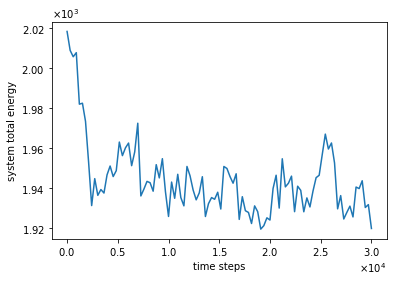

In [13]:
plt.ion()
ts = np.linspace(0,N_frames*steps_per_frame, num = N_frames)
fig1 = plt.figure()
#plot time in time_steps so we can judge the number of warmup steps and the steps per frame for uncorrelated data
plt.plot(ts, energies)
plt.xlabel('time steps')
plt.ylabel('system total energy')

In [14]:
#use the plot to determine the warmup time and the appropriate number of steps per frame
warmup_steps = 5000

N_frames = 1000
steps_per_frame = 200

In [15]:
def clear_system(system):
    system.thermostat.turn_off()
    system.part.clear()
    system.time = 0.
    

In [16]:
clear_system(system)

In [17]:
#TODO replace this function by more intuitive behaviour of p3m.tune()
def retune_p3m(p3m):
    #reset p3m tunable parameters to default to force a retune
    p3m_default_params = p3m.default_params()
    p3m.tune(mesh = p3m_default_params['mesh'],
             cao = p3m_default_params['cao'],
             r_cut = 0,
             #TODO change default value in interface
             alpha = p3m_default_params['alpha'])

In [18]:
#run the system with different parameter sets but same manning parameter
runs = [{'params':{'counterion_valency':2, 'rod_charge_dens':1},
         'distances':None},
        {'params':{'counterion_valency':1, 'rod_charge_dens':2},
         'distances':None}
       ]

for run in runs:
    setup_rod_and_ions(system, run['params']['counterion_valency'], counterion_type,
                 run['params']['rod_charge_dens'], N_rod_beads, rod_type)
    retune_p3m(p3m)
    remove_overlap(system, STEEPEST_DESCENT_PARAMS)
    system.thermostat.set_langevin(**langevin_params)
    system.integrator.run(warmup_steps)
    print('setup and warmup done, starting simulation')
    energies, distances = integrate_calc_observables(system, N_frames, 
                                       steps_per_frame, [counterion_type])
    clear_system(system)
    run['distances'] = distances[counterion_type]
    print('simulation for parameters {} done\n'.format(run['params']))

P3M tune parameters: Accuracy goal = 9.94603e-04 prefactor = 1.00000e+00
System: box_l = 2.40000e+01 # charged part = 62 Sum[q_i^2] = 5.95200e+01
mesh cao r_cut_iL     alpha_L      err          rs_err     ks_err     time [ms]
4    7   cao too large for this mesh
6    7   cao too large for this mesh
10   7   2.54883e-01 8.13852e+00 9.85134e-04 7.033e-04 6.898e-04 0.56    
10   6   2.60547e-01 7.95142e+00 9.83737e-04 7.033e-04 6.878e-04 0.38    
10   5   2.70931e-01 7.62923e+00 9.89206e-04 7.033e-04 6.956e-04 0.29    
10   4   2.91699e-01 7.05536e+00 9.88295e-04 7.033e-04 6.943e-04 0.25    
10   3   3.42676e-01 5.94843e+00 9.93518e-04 7.033e-04 7.018e-04 0.24    
10   2   4.83333e-01 4.12915e+00 1.34830e-03 7.033e-04 1.150e-03 accuracy not achieved
12   3   2.94487e-01 6.98465e+00 9.91926e-04 7.033e-04 6.995e-04 0.30    
12   2   3.42676e-01 5.94843e+00 2.09128e-03 7.033e-04 1.969e-03 accuracy not achieved
12   4   2.48975e-01 8.34296e+00 9.92336e-04 7.033e-04 7.001e-04 0.30    
12   5  

setup and warmup done, starting simulation
simulation for parameters {'counterion_valency': 1, 'rod_charge_dens': 2} done



In [19]:
#Q: why does the second simulation take much longer?
#A: double the charge, half the valency => 4x more ions to be integrated

In [20]:
def calc_cum_hist(values, bins, normalize = True):
    hist, bins = np.histogram(values, bins=log_bins)
    cum_hist = np.cumsum(hist)
    if normalize:
        cum_hist = cum_hist/cum_hist[-1]
    return cum_hist

Text(0, 0.5, 'P(r)')

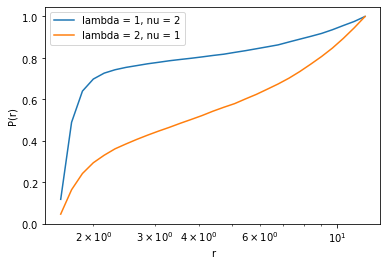

In [21]:
log_bins=np.logspace(np.log10(rod_radius+ion_diameter/2.), np.log10(rod_length/2.),num=30)

fig, ax = plt.subplots()
for run in runs:
    cum_hist = calc_cum_hist(run['distances'], log_bins)
    ax.plot(log_bins[1:],cum_hist, label = 'lambda = {}, nu = {}'.format(run['params']['rod_charge_dens'], 
                                                                          run['params']['counterion_valency']))
    
ax.set_xscale('log')
ax.legend()
plt.xlabel('r')
plt.ylabel('P(r)')

In [22]:
def eq_to_solve_for_gamma(gamma, manning_parameter, rod_radius, max_radius):
    #eq 7 - eq 6 from 10.1021/ma990897o
    return gamma*np.log(max_radius/rod_radius) - np.arctan(1/gamma) + np.arctan((1-manning_parameter)/gamma)

def calc_manning_radius(gamma,max_radius):
    #eq 7 from 10.1021/ma990897o
    return max_radius*np.exp(-np.arctan(1./gamma)/gamma)  

def calc_PB_probability(r, manning_parameter, gamma, manning_radius):
    #eq 8 and 9 from 10.1021/ma990897o
    return 1./manning_parameter + gamma/manning_parameter * np.tan(gamma*np.log(r/manning_radius))


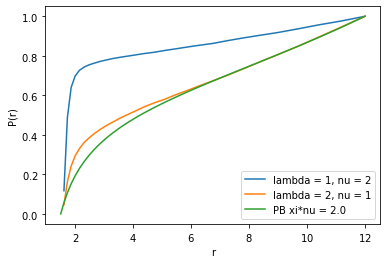

In [23]:
rod_charge_density = runs[0]['params']['rod_charge_dens']
ion_valency = runs[0]['params']['counterion_valency']
manning_parameter_times_valency = bjerrum_length*rod_charge_density*ion_valency
#for multivalent ions, the manning parameter xi has to be multiplied by the valency.
#the result therefore depends only on the product of rod_charge_dens and ion_velancy, so we only need one curve

gamma = optimize.fsolve(eq_to_solve_for_gamma, 1, args = (manning_parameter_times_valency,rod_radius+ion_diameter/2.,rod_length/2.))
manning_radius = calc_manning_radius(gamma, rod_length/2.)

PB_probability = calc_PB_probability(log_bins, manning_parameter_times_valency,gamma, manning_radius)


ax.plot(log_bins, PB_probability, label = f'PB xi*nu = {manning_parameter_times_valency}')
ax.legend()
ax.set_xscale('linear')
fig

In [24]:
# overcharging through added salt

In [25]:
def add_salt(system, anion_params, cation_params):        
    for _ in range(anion_params['number']):
        system.part.add(pos=np.random.random(3) * system.box_l, 
                        type=anion_params['type'], q=-anion_params['valency'])
        
    for _ in range(cation_params['number']):
        system.part.add(pos=np.random.random(3) * system.box_l, 
                        type=cation_params['type'], q=cation_params['valency'])
    

In [32]:
anion_params = {'type':3,
                'valency':2,
                'number':500}
cation_params = {'type':4,
                 'valency':2,
                 'number':500}
rod_length = 62.5

total_anion_charge = -anion_params['number']*anion_params['valency']
total_cation_charge = cation_params['number']*cation_params['valency']
assert( abs(total_anion_charge+ total_cation_charge)/total_cation_charge < 1e-10)

counterion_valency = 1 
rod_charge_dens = 1

all_ion_types = [counterion_type, anion_params['type'],cation_params['type'] ]

#set interactions of salt with the rod and all ions
for salt_type in [anion_params['type'], cation_params['type']]:
    system.non_bonded_inter[salt_type,rod_type].wca.set_params(
          epsilon=wca_epsilon, sigma=ion_diameter/2. + rod_radius)
    for ion_type in all_ion_types:
        system.non_bonded_inter[salt_type,ion_type].wca.set_params(
          epsilon=wca_epsilon, sigma=ion_diameter)
    



In [33]:
clear_system(system)
system.box_l = 3*[rod_length]
setup_rod_and_ions(system, counterion_valency, counterion_type,
                   rod_charge_dens, N_rod_beads, rod_type)
add_salt(system, anion_params, cation_params)
retune_p3m(p3m)
remove_overlap(system, STEEPEST_DESCENT_PARAMS)
system.thermostat.set_langevin(**langevin_params)
system.integrator.run(warmup_steps)
print('setup and warmup done, starting simulation')
energies, distances = integrate_calc_observables(system, N_frames, 
                                   steps_per_frame, all_ion_types)
print('simulation done')


P3M tune parameters: Accuracy goal = 9.79494e-04 prefactor = 1.00000e+00
System: box_l = 1.20000e+01 # charged part = 262 Sum[q_i^2] = 8.14880e+02
mesh cao r_cut_iL     alpha_L      err          rs_err     ks_err     time [ms]
6    7   cao too large for this mesh
8    7   4.66667e-01 5.78902e+00 6.26342e-03 6.926e-04 6.225e-03 accuracy not achieved
10   7   4.66667e-01 5.78902e+00 1.07985e-03 6.926e-04 8.285e-04 accuracy not achieved
10   7   4.66667e-01 5.78902e+00 1.07985e-03 6.926e-04 8.285e-04 accuracy not achieved
12   7   4.01953e-01 6.75531e+00 9.77325e-04 6.926e-04 6.895e-04 2.08    
12   6   4.23828e-01 6.39513e+00 9.73198e-04 6.926e-04 6.837e-04 1.94    
12   5   4.66667e-01 5.78902e+00 9.74087e-04 6.926e-04 6.849e-04 2.10    
12   4   4.66667e-01 5.78902e+00 2.22585e-03 6.926e-04 2.115e-03 accuracy not achieved
12   6   4.23828e-01 6.39513e+00 9.73198e-04 6.926e-04 6.837e-04 1.92    
12   5   4.23828e-01 6.39513e+00 1.60219e-03 6.926e-04 1.445e-03 accuracy not achieved
12   

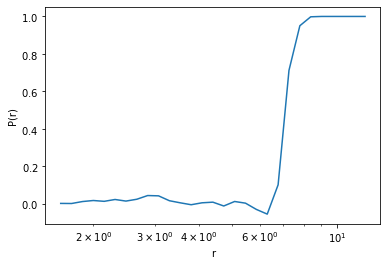

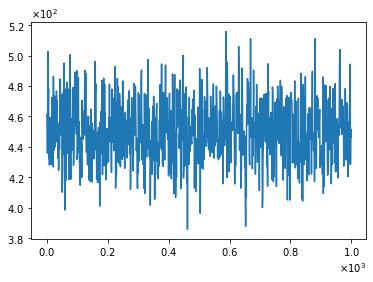

In [34]:
#do not normalize the histograms because there are a different number of the ion types
counterion_hist = calc_cum_hist(distances[counterion_type], log_bins, normalize = False)
anion_hist = calc_cum_hist(distances[anion_params['type']], log_bins, normalize = False)
cation_hist = calc_cum_hist(distances[cation_params['type']], log_bins, normalize = False)

charge_hist = cation_params['valency'] * cation_hist - anion_params['valency'] * anion_hist - counterion_valency * counterion_hist
charge_hist = charge_hist/charge_hist[-1]
#we know the system in total is neutral, so we can normalize the total histogram to the rod charge


fig2, ax2 = plt.subplots()
#normalize the histogram by the rod charge
ax2.plot(log_bins[1:], charge_hist)
ax2.set_xscale('log')
plt.xlabel('r')
plt.ylabel('P(r)')

fig = plt.figure()
plt.plot(energies)
plt.show()
